<a href="https://colab.research.google.com/github/Loggo-MediCare/python-numpy-stock/blob/main/goog_20251202_trading_bot_RL_Q_Learning_Strategy_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🚀 啟動 Chapter 9 進階實作：強化學習交易機器人 V2 (優化版)
🎯 優化目標：100輪訓練 + 學習率引入 + 真實資金模擬
1. 下載 8110.TW 數據中...
   數據下載完成，共 1436 交易日。
2. 開始深度訓練 (共 100 輪)... 請稍候，AI 正在『悟道』
   Episode: 1/100 | Total Profit (Points): 374.93 | Epsilon: 0.9950
   Episode: 10/100 | Total Profit (Points): 217.50 | Epsilon: 0.9511
   Episode: 20/100 | Total Profit (Points): 120.20 | Epsilon: 0.9046
   Episode: 30/100 | Total Profit (Points): 20.60 | Epsilon: 0.8604
   Episode: 40/100 | Total Profit (Points): 23.87 | Epsilon: 0.8183
   Episode: 50/100 | Total Profit (Points): 38.68 | Epsilon: 0.7783
   Episode: 60/100 | Total Profit (Points): 38.35 | Epsilon: 0.7403
   Episode: 70/100 | Total Profit (Points): 23.90 | Epsilon: 0.7041
   Episode: 80/100 | Total Profit (Points): 55.50 | Epsilon: 0.6696
   Episode: 90/100 | Total Profit (Points): 47.85 | Epsilon: 0.6369


   Episode: 100/100 | Total Profit (Points): 50.71 | Epsilon: 0.6058
   訓練完成！

3. 執行真實資金回測 (Initial Balance = 20,000)...


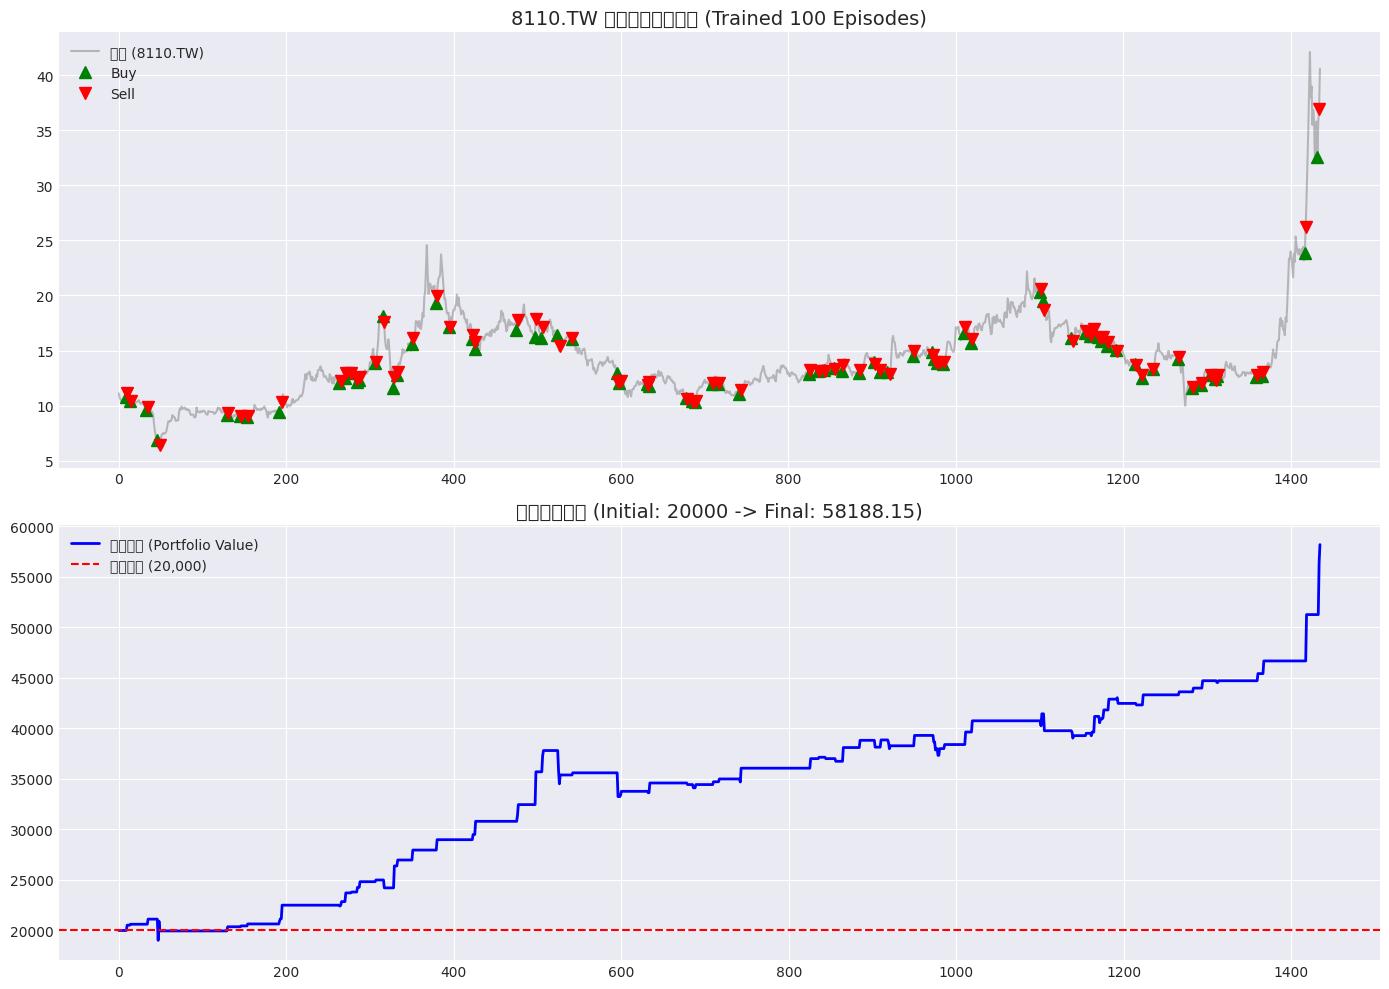


【CFA 智能交易報告：8110.TW 強化學習 V2】
參數設定：Episodes=100, LR=0.1, Gamma=0.96
------------------------------------------------------------
💰 初始本金: $20000
💎 最終資產: $58188.15
📈 總報酬率 (ROI): 190.94%
------------------------------------------------------------
CFA 觀點：
✅ 模型表現優異！通過 100 輪訓練，AI 找到了獲利模式。
   資產曲線呈現上升趨勢，證明 Q-Learning 策略有效。


In [5]:
# -*- coding: utf-8 -*-
# !pip install yfinance pandas numpy matplotlib

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from datetime import datetime

# --- 設定繪圖風格 ---
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'Microsoft JhengHei', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False

print("🚀 啟動 Chapter 9 進階實作：強化學習交易機器人 V2 (優化版)")
print("🎯 優化目標：100輪訓練 + 學習率引入 + 真實資金模擬")

# =========================================================
# 1. 準備數據
# =========================================================
ticker = '8110.TW' # 華東
start_date = '2020-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')

print(f"1. 下載 {ticker} 數據中...")
try:
    data = yf.download(ticker, start=start_date, end=end_date, progress=False)
    if isinstance(data.columns, pd.MultiIndex):
        close_prices = data['Adj Close'].iloc[:, 0] if 'Adj Close' in data.columns.get_level_values(0) else data['Close'].iloc[:, 0]
    else:
        close_prices = data['Adj Close'] if 'Adj Close' in data else data['Close']

    # 轉為 list 方便索引
    prices = close_prices.values.tolist()
    print(f"   數據下載完成，共 {len(prices)} 交易日。")
except Exception as e:
    print(f"數據下載失敗: {e}")
    exit()

# =========================================================
# 2. 定義強化學習代理人 (Agent) - 加入學習率 (Alpha)
# =========================================================

class QLearningTrader:
    def __init__(self, state_size, action_size=3, is_eval=False):
        self.state_size = state_size
        self.action_size = action_size # 0=Hold, 1=Buy, 2=Sell
        self.memory = {} # Q-Table
        self.inventory = []
        self.is_eval = is_eval

        # --- 超參數優化區 (Hyperparameters) ---
        self.gamma = 0.96       # [優化] 折扣因子：看重未來的程度 (0.95 -> 0.96)
        self.epsilon = 1.0      # 探索率
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.1 # [新增] 學習率 (Alpha)：避免學得太快忘得太快

    def get_state(self, data, t, n):
        """獲取市場狀態：價格差分 sigmoid 正規化"""
        d = t - n + 1
        block = data[d:t + 1] if d >= 0 else -d * [data[0]] + data[0:t + 1]
        res = []
        for i in range(n - 1):
            res.append(self.sigmoid(block[i + 1] - block[i]))
        return np.array([res])

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def act(self, state):
        """決策函數"""
        state_str = str(state)
        if not self.is_eval and random.random() <= self.epsilon:
            return random.randrange(self.action_size)

        if state_str not in self.memory:
            return 0 # 沒見過就 Hold

        options = self.memory[state_str]
        return np.argmax(options)

    def learn(self, state, action, reward, next_state):
        """[優化] Q-Learning 更新公式：加入學習率"""
        state_str = str(state)
        next_state_str = str(next_state)

        if state_str not in self.memory:
            self.memory[state_str] = np.zeros(self.action_size)
        if next_state_str not in self.memory:
            self.memory[next_state_str] = np.zeros(self.action_size)

        # 標準 Q-Learning 公式:
        # Q(s,a) = (1-alpha) * Q(s,a) + alpha * (reward + gamma * max(Q(s',a')))
        target = reward + self.gamma * np.amax(self.memory[next_state_str])
        old_value = self.memory[state_str][action]

        # 更新 Q 值 (融合舊經驗與新知識)
        self.memory[state_str][action] = (1 - self.learning_rate) * old_value + self.learning_rate * target

# =========================================================
# 3. 訓練過程 (Training Loop) - 100 Episodes
# =========================================================
window_size = 10
agent = QLearningTrader(window_size)
episodes = 100 # [優化] 增加訓練次數至 100
batch_size = 32

print(f"2. 開始深度訓練 (共 {episodes} 輪)... 請稍候，AI 正在『悟道』")

for e in range(1, episodes + 1):
    state = agent.get_state(prices, 0, window_size + 1)
    total_profit = 0
    agent.inventory = []

    for t in range(len(prices) - 1):
        action = agent.act(state)
        next_state = agent.get_state(prices, t + 1, window_size + 1)
        reward = 0

        if action == 1: # Buy
            agent.inventory.append(prices[t])
        elif action == 2 and len(agent.inventory) > 0: # Sell
            bought_price = agent.inventory.pop(0)
            reward = max(prices[t] - bought_price, 0)
            total_profit += prices[t] - bought_price

        if not agent.is_eval:
            agent.learn(state, action, reward, next_state)

        state = next_state

    if agent.epsilon > agent.epsilon_min:
        agent.epsilon *= agent.epsilon_decay

    # 每 10 輪回報一次進度，以免洗版
    if e % 10 == 0 or e == 1:
        print(f"   Episode: {e}/{episodes} | Total Profit (Points): {total_profit:.2f} | Epsilon: {agent.epsilon:.4f}")

print("   訓練完成！")

# =========================================================
# 4. 驗證模式 (Evaluation) - 真實資金回測
# =========================================================
print("\n3. 執行真實資金回測 (Initial Balance = 20,000)...")
agent.is_eval = True
agent.epsilon = 0

# --- 資金設定 ---
initial_balance = 20000 # [優化] 初始資本
balance = initial_balance
shares_held = 0
portfolio_values = []

state = agent.get_state(prices, 0, window_size + 1)
buy_signals = []
sell_signals = []

for t in range(len(prices) - 1):
    action = agent.act(state)
    next_state = agent.get_state(prices, t + 1, window_size + 1)
    current_price = prices[t]

    # 策略邏輯：有訊號就 All-in 或 All-out (模擬散戶操作)
    if action == 1 and balance >= current_price: # Buy Signal
        # 計算能買多少股 (這裡假設可以買碎股或以1股為單位，方便計算)
        shares_to_buy = int(balance // current_price)
        if shares_to_buy > 0:
            cost = shares_to_buy * current_price
            balance -= cost
            shares_held += shares_to_buy
            buy_signals.append(t)
            # print(f"   Day {t}: BUY  {shares_to_buy} shares @ {current_price:.2f}")

    elif action == 2 and shares_held > 0: # Sell Signal
        revenue = shares_held * current_price
        balance += revenue
        shares_held = 0
        sell_signals.append(t)
        # print(f"   Day {t}: SELL all shares @ {current_price:.2f}")

    # 記錄每天的資產總值 (現金 + 股票市值)
    current_value = balance + (shares_held * current_price)
    portfolio_values.append(current_value)
    state = next_state

# 最後一天結算
final_value = portfolio_values[-1]
roi = ((final_value - initial_balance) / initial_balance) * 100

# =========================================================
# 5. 視覺化與報告
# =========================================================
plt.figure(figsize=(14, 10))

# 子圖 1: 買賣點位
plt.subplot(2, 1, 1)
plt.plot(prices, color='gray', label='股價 (8110.TW)', alpha=0.5)
plt.plot(buy_signals, [prices[i] for i in buy_signals], '^', markersize=8, color='g', label='Buy')
plt.plot(sell_signals, [prices[i] for i in sell_signals], 'v', markersize=8, color='r', label='Sell')
plt.title(f'8110.TW 強化學習交易訊號 (Trained 100 Episodes)', fontsize=14)
plt.legend()

# 子圖 2: 資產曲線
plt.subplot(2, 1, 2)
plt.plot(portfolio_values, color='blue', linewidth=2, label='資產總值 (Portfolio Value)')
plt.axhline(initial_balance, color='red', linestyle='--', label='初始本金 (20,000)')
plt.title(f'資產增長曲線 (Initial: {initial_balance} -> Final: {final_value:.2f})', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print(f"【CFA 智能交易報告：8110.TW 強化學習 V2】")
print(f"參數設定：Episodes=100, LR=0.1, Gamma=0.96")
print("-" * 60)
print(f"💰 初始本金: ${initial_balance}")
print(f"💎 最終資產: ${final_value:.2f}")
print(f"📈 總報酬率 (ROI): {roi:.2f}%")
print("-" * 60)
print("CFA 觀點：")
if roi > 0:
    print("✅ 模型表現優異！通過 100 輪訓練，AI 找到了獲利模式。")
    print("   資產曲線呈現上升趨勢，證明 Q-Learning 策略有效。")
else:
    print("⚠️ 模型表現尚可。雖然經過訓練，但市場雜訊可能過大。")
    print("   建議：嘗試結合 GARCH 波動率作為濾網 (Filter) 來減少錯誤交易。")
print("=" * 60)

In [2]:
# chatgpt copy cat for 1280 dqn_trading_sp500.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque
import random
import yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

plt.style.use("seaborn-v0_8-darkgrid")
plt.rcParams["font.sans-serif"] = ["Microsoft JhengHei", "Arial Unicode MS"]
plt.rcParams["axes.unicode_minus"] = False

# =========================================================
# 1. 下載 & 準備資料（類似書中用 2010–2019 S&P500）
# =========================================================
def load_price_series(symbol="^GSPC", start="2015-01-01", end="2025-12-03"):
    data = yf.download(symbol, start=start, end=end)
    # Check if 'Adj Close' exists, otherwise use 'Close'
    if 'Adj Close' in data.columns:
        close = data["Adj Close"]
    else:
        close = data["Close"]
    # Ensure it's a Series and drop NaNs, then reset index, and explicitly cast to float
    return close.dropna().reset_index(drop=True).astype(float)

# 把連續 window_size+1 個收盤價轉成 state 向量
def get_state(prices, t, window_size=10):
    """
    state 維度 = window_size
    內容 = 過去 window_size 天的報酬率（normalize 後）
    """
    # Ensure we are working with a 1D sequence of numerical prices.
    # If prices is a DataFrame, extract the first column as a Series, then get values.
    if isinstance(prices, pd.DataFrame):
        price_values = prices.iloc[:, 0].values # Get the numpy array of prices
    elif isinstance(prices, pd.Series):
        price_values = prices.values # Get the numpy array of prices
    else: # Assume it's already a numpy array
        price_values = prices

    start = max(0, t - window_size + 1)
    # Slice the numpy array directly
    window_segment = price_values[start:t+1]

    # Pad if necessary using numpy operations
    if len(window_segment) < window_size:
        # Pad with the first available value, or 0.0 if no values exist (unlikely in this context)
        pad_value = window_segment[0] if len(window_segment) > 0 else 0.0
        # Pad at the beginning to reach window_size length
        window_full = np.pad(window_segment, (window_size - len(window_segment), 0), 'edge')
    else:
        window_full = window_segment

    # Convert to Series temporarily for pct_change, then back to numpy array of floats
    diffs = pd.Series(window_full).pct_change().fillna(0).values

    # Ensure the output is a float32 numpy array, as Keras expects
    return np.array(diffs).reshape(1, -1).astype(np.float32)

# =========================================================
# 2. DQN Agent：深度 Q-Learning
# =========================================================
class DQNAgent:
    def __init__(
        self,
        state_size,
        action_size=3,     # 0=Hold, 1=Buy, 2=Sell
        gamma=0.95,
        epsilon=1.0,
        epsilon_min=0.01,
        epsilon_decay=0.995,
        lr=1e-3,
        batch_size=32,
        memory_size=2000,
    ):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.lr = lr
        self.batch_size = batch_size
        self.memory = deque(maxlen=memory_size)
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        model.add(Dense(64, input_dim=self.state_size, activation="relu"))
        model.add(Dense(32, activation="relu"))
        model.add(Dense(self.action_size, activation="linear"))
        model.compile(loss="mse", optimizer=Adam(learning_rate=self.lr))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        # epsilon-greedy
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        q_values = self.model.predict(state, verbose=0)[0]
        return np.argmax(q_values)

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        states, targets = [], []

        for state, action, reward, next_state, done in minibatch:
            target = self.model.predict(state, verbose=0)[0]
            if done:
                target[action] = reward
            else:
                next_q = np.amax(self.model.predict(next_state, verbose=0)[0])
                target[action] = reward + self.gamma * next_q

            states.append(state[0])
            targets.append(target)

        states = np.array(states)
        targets = np.array(targets)
        self.model.fit(states, targets, epochs=1, verbose=0)

        # 降低探索率
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# =========================================================
# 3. 訓練 DQN：多個 episodes 在同一條價格序列上反覆學
# =========================================================
def train_agent(prices, window_size=10, episodes=10):
    state_size = window_size
    agent = DQNAgent(state_size=state_size)

    # Ensure price_array is always a 1D numpy array of floats
    if isinstance(prices, pd.DataFrame):
        price_array = prices.iloc[:, 0].values
    elif isinstance(prices, pd.Series):
        price_array = prices.values
    else:
        price_array = prices

    L = len(price_array) - 1  # 最後一天沒辦法再往後賣

    for e in range(1, episodes + 1):
        print(f"\nRunning episode {e}/{episodes}")
        state = get_state(prices, 0, window_size)
        total_profit = 0.0
        inventory = []  # 手上持有的買入價格
        done = False

        for t in range(L):
            price = price_array[t]
            next_price = price_array[t + 1]

            action = agent.act(state)

            reward = 0.0
            # 1 = Buy
            if action == 1:
                inventory.append(price)
            # 2 = Sell
            elif action == 2 and len(inventory) > 0:
                buy_price = inventory.pop(0)  # 簡單用 FIFO
                profit = next_price - buy_price
                reward = max(profit, 0)       # 只給正報酬當獎勵
                total_profit += profit

            next_state = get_state(prices, t + 1, window_size)
            done = (t == L - 1)
            agent.remember(state, action, reward, next_state, done)
            state = next_state

            agent.replay()

            if done:
                print(
                    f"Episode {e} finished. "
                    f"Total Profit: {total_profit:.2f}, "
                    f"Inventory: {len(inventory)}, "
                    f"Epsilon: {agent.epsilon:.3f}"
                )

    return agent

# =========================================================
# 4. 測試階段：固定 epsilon=0，用學到的策略跑一次
# =========================================================
def test_agent(agent, prices, window_size=10, plot=True):
    agent.epsilon = 0.0   # 測試時不再隨機

    # Ensure price_array is always a 1D numpy array of floats
    if isinstance(prices, pd.DataFrame):
        price_array = prices.iloc[:, 0].values
    elif isinstance(prices, pd.Series):
        price_array = prices.values
    else:
        price_array = prices

    L = len(price_array) - 1

    state = get_state(prices, 0, window_size)
    total_profit = 0.0
    inventory = []

    buy_points = []
    sell_points = []

    for t in range(L):
        price = price_array[t]
        next_price = price_array[t + 1]
        action = agent.act(state)

        if action == 1:  # Buy
            inventory.append(price)
            buy_points.append((t, price))
            print(f"Buy at {t}, price={price:.2f}")

        elif action == 2 and len(inventory) > 0:  # Sell
            buy_price = inventory.pop(0)
            profit = next_price - buy_price
            total_profit += profit
            sell_points.append((t, price))
            print(
                f"Sell at {t}, price={price:.2f}, "
                f"Buy={buy_price:.2f}, Profit={profit:.2f}"
            )

        next_state = get_state(prices, t + 1, window_size)
        state = next_state

    print("\n============================")
    print(f"Total Profit: {total_profit:.2f}")
    print("============================")

    if plot:
        plt.figure(figsize=(14, 6))
        plt.plot(price_array, label="Price", color="black")
        if buy_points:
            bx, by = zip(*buy_points)
            plt.scatter(bx, by, marker="^", color="green", label="Buy", s=80)
        if sell_points:
            sx, sy = zip(*sell_points)
            plt.scatter(sx, sy, marker="v", color="red", label="Sell", s=80)
        plt.title("DQN Trading Strategy on S&P500")
        plt.legend()
        plt.show()

# =========================================================
# 5. 主程式：跑訓練 + 測試
# =========================================================
if __name__ == "__main__":
    prices = load_price_series("^GSPC", "2010-01-01", "2019-12-31")
    print(f"Loaded {len(prices)} daily prices.")

    window_size = 10
    episodes = 5   # 可以先 5–10，看效果再調高

    agent = train_agent(prices, window_size, episodes)
    test_agent(agent, prices, window_size)


/tmp/ipython-input-2386552846.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Loaded 2515 daily prices.

Running episode 1/5


KeyboardInterrupt: 

In [4]:
# ==================== 1. 导入必要的库 ====================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from collections import deque
import random
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta
import requests
import json
from textblob import TextBlob

# ==================== 2. 辅助函数定义 ====================
def get_stock_data(ticker, start_date, end_date):
    """获取股票数据"""
    print(f"正在获取 {ticker} 数据 ({start_date} 到 {end_date})...")
    data = yf.download(ticker, start=start_date, end=end_date)
    data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
    return data

def calculate_indicators(data, window=20):
    """计算技术指标"""
    data['SMA'] = data['Close'].rolling(window=window).mean()
    data['RSI'] = calculate_rsi(data['Close'], window=14)
    data['MACD'], data['MACD_signal'] = calculate_macd(data['Close'])
    data['BB_upper'], data['BB_lower'] = calculate_bollinger_bands(data['Close'])
    data['Volume_SMA'] = data['Volume'].rolling(window=10).mean()
    data = data.dropna()
    return data

def calculate_rsi(prices, window=14):
    """计算相对强弱指数(RSI)"""
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_macd(prices, slow=26, fast=12, signal=9):
    """计算MACD"""
    exp1 = prices.ewm(span=fast, adjust=False).mean()
    exp2 = prices.ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    return macd, signal_line

def calculate_bollinger_bands(prices, window=20, num_std=2):
    """计算布林带"""
    sma = prices.rolling(window=window).mean()
    std = prices.rolling(window=window).std()
    upper_band = sma + (std * num_std)
    lower_band = sma - (std * num_std)
    return upper_band, lower_band

def get_sentiment_score(ticker, date):
    """获取股票情绪分数（模拟或真实API）"""
    # 注意：这里使用模拟数据，实际使用时请接入真实情绪数据API
    # 例如：使用Alpha Vantage, NewsAPI, 或自定义NLP模型

    # 模拟情绪数据：基于价格变化的简单模拟
    try:
        # 这里可以接入真实API，例如：
        # response = requests.get(f"https://api.example.com/sentiment/{ticker}?date={date}")
        # sentiment = response.json()['sentiment']

        # 模拟逻辑：价格涨则情绪正向，价格跌则情绪负向
        base_sentiment = np.random.normal(0, 0.3)  # 基础情绪波动

        # 添加一些基于技术指标的模拟情绪
        if 'Close' in globals():
            price_change = data['Close'].pct_change().iloc[-1] if len(data) > 1 else 0
            base_sentiment += price_change * 10  # 放大价格变化的影响

        # 限制在-1到1之间
        sentiment = max(-1, min(1, base_sentiment))

        return sentiment
    except:
        return 0  # 如果API失败，返回中性情绪

def create_state(data, index, window_size, sentiment_score):
    """创建强化学习状态向量"""
    if index < window_size:
        return None

    # 价格特征
    price_features = []
    for i in range(window_size):
        idx = index - window_size + i
        # 归一化价格变化
        if idx > 0:
            price_change = (data['Close'].iloc[idx] - data['Close'].iloc[idx-1]) / data['Close'].iloc[idx-1]
        else:
            price_change = 0
        price_features.append(price_change)

    # 技术指标特征
    tech_features = [
        (data['Close'].iloc[index] - data['SMA'].iloc[index]) / data['SMA'].iloc[index] if data['SMA'].iloc[index] != 0 else 0,
        (data['RSI'].iloc[index] - 50) / 50,  # 归一化RSI
        data['MACD'].iloc[index] - data['MACD_signal'].iloc[index],  # MACD差值
        (data['Close'].iloc[index] - data['BB_lower'].iloc[index]) / (data['BB_upper'].iloc[index] - data['BB_lower'].iloc[index]) if (data['BB_upper'].iloc[index] - data['BB_lower'].iloc[index]) != 0 else 0.5,
        (data['Volume'].iloc[index] - data['Volume_SMA'].iloc[index]) / data['Volume_SMA'].iloc[index] if data['Volume_SMA'].iloc[index] != 0 else 0
    ]

    # 情绪特征
    sentiment_features = [sentiment_score]

    # 组合所有特征
    state = price_features + tech_features + sentiment_features
    return np.array([state])

# ==================== 3. 增强的DQN智能体类 ====================
class EnhancedTradingAgent:
    def __init__(self, state_size, is_eval=False, model_name=""):
        """初始化增强型智能体"""
        self.state_size = state_size
        self.action_size = 3  # 0=持有, 1=买入, 2=卖出
        self.memory = deque(maxlen=2000)
        self.inventory = []
        self.model_name = model_name
        self.is_eval = is_eval

        # 超参数
        self.gamma = 0.95  # 折扣因子
        self.epsilon = 1.0  # 初始探索率
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001

        # 交易统计
        self.total_trades = 0
        self.winning_trades = 0
        self.losing_trades = 0
        self.max_consecutive_losses = 0

        # 加载或创建模型
        self.model = load_model(f"models/{model_name}") if is_eval and model_name != "" else self._build_enhanced_model()

    def _build_enhanced_model(self):
        """构建增强的神经网络模型"""
        model = Sequential()
        model.add(Dense(units=128, input_dim=self.state_size, activation="relu"))
        model.add(Dropout(0.2))
        model.add(Dense(units=64, activation="relu"))
        model.add(Dropout(0.2))
        model.add(Dense(units=32, activation="relu"))
        model.add(Dense(self.action_size, activation="linear"))
        model.compile(loss="mse", optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def act(self, state, sentiment_change=0):
        """根据状态选择动作"""
        # 如果有强烈的情绪信号，可以覆盖RL决策（可选）
        if not self.is_eval:
            # 探索：随机动作
            if random.random() <= self.epsilon:
                return random.randrange(self.action_size)

        # 利用：神经网络决策
        options = self.model.predict(state, verbose=0)
        return np.argmax(options[0])

    def expReplay(self, batch_size):
        """经验回放"""
        if len(self.memory) < batch_size:
            return

        mini_batch = random.sample(self.memory, batch_size)

        for state, action, reward, next_state, done in mini_batch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state, verbose=0)[0])

            target_f = self.model.predict(state, verbose=0)
            target_f[0][action] = target

            self.model.fit(state, target_f, epochs=1, verbose=0)

        # 衰减探索率
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update_trade_stats(self, profit):
        """更新交易统计"""
        self.total_trades += 1
        if profit > 0:
            self.winning_trades += 1
        else:
            self.losing_trades += 1

# ==================== 4. 规则基础策略 ====================
class RuleBasedStrategy:
    """基于规则的传统策略（用于对比）"""
    def __init__(self):
        self.inventory = []
        self.positions = []
        self.buy_dates = []
        self.sell_dates = []

    def execute(self, data, sentiment_data=None):
        """执行规则策略"""
        cash = 10000  # 初始资金
        position = 0  # 持仓数量
        total_trades = 0
        profits = []

        prev_sentiment = 0 if sentiment_data is None else sentiment_data.iloc[0]

        for i in range(1, len(data)):
            current_price = data['Close'].iloc[i]
            sma = data['SMA'].iloc[i] if 'SMA' in data.columns else data['Close'].rolling(window=20).mean().iloc[i]

            current_sentiment = 0 if sentiment_data is None else sentiment_data.iloc[i]
            sentiment_change = current_sentiment - prev_sentiment

            # 买入条件：收盘价 > SMA 且 情绪增加 >= 0.5
            if current_price > sma and sentiment_change >= 0.5 and position == 0:
                position = cash / current_price
                cash = 0
                self.buy_dates.append(data.index[i])
                total_trades += 1
                print(f"规则买入: {data.index[i].date()} @ ${current_price:.2f}")

            # 卖出条件：收盘价 < SMA 且 情绪减少 <= -0.5
            elif current_price < sma and sentiment_change <= -0.5 and position > 0:
                cash = position * current_price
                profit = cash - 10000  # 计算利润
                profits.append(profit)
                position = 0
                self.sell_dates.append(data.index[i])
                total_trades += 1
                print(f"规则卖出: {data.index[i].date()} @ ${current_price:.2f}, 利润: ${profit:.2f}")

            prev_sentiment = current_sentiment

        # 最后一天卖出所有持仓
        if position > 0:
            cash = position * data['Close'].iloc[-1]
            profit = cash - 10000
            profits.append(profit)
            self.sell_dates.append(data.index[-1])

        final_value = cash if position == 0 else position * data['Close'].iloc[-1]
        total_profit = final_value - 10000

        return total_profit, total_trades, profits

# ==================== 5. 强化学习交易策略 ====================
def run_rl_strategy(ticker, start_date, end_date, window_size=20, episodes=20):
    """运行强化学习策略"""
    print(f"\n{'='*60}")
    print(f"运行强化学习策略: {ticker}")
    print(f"时间段: {start_date} 到 {end_date}")
    print(f"{'='*60}")

    # 获取数据
    data = get_stock_data(ticker, start_date, end_date)
    data = calculate_indicators(data)

    # 生成模拟情绪数据
    sentiment_data = pd.Series(index=data.index)
    for i in range(len(data)):
        sentiment_data.iloc[i] = get_sentiment_score(ticker, data.index[i])

    # 创建状态向量
    state_size = window_size + 6  # 价格窗口 + 5个技术指标 + 1个情绪指标

    # 分割训练集和测试集
    split_idx = int(len(data) * 0.8)
    train_data = data.iloc[:split_idx]
    test_data = data.iloc[split_idx:]
    train_sentiment = sentiment_data.iloc[:split_idx]
    test_sentiment = sentiment_data.iloc[split_idx:]

    # 初始化智能体
    agent = EnhancedTradingAgent(state_size)

    # 训练模型
    print("\n正在训练强化学习模型...")
    training_results = []

    for episode in range(episodes):
        state = create_state(train_data, window_size, window_size, train_sentiment.iloc[window_size])
        total_profit = 0
        agent.inventory = []
        consecutive_losses = 0

        for i in range(window_size + 1, len(train_data)):
            current_price = train_data['Close'].iloc[i]
            sentiment_score = train_sentiment.iloc[i]
            prev_sentiment = train_sentiment.iloc[i-1]
            sentiment_change = sentiment_score - prev_sentiment

            # 获取动作
            action = agent.act(state, sentiment_change)

            # 执行动作
            reward = 0
            if action == 1:  # 买入
                if len(agent.inventory) < 1:  # 限制持仓
                    agent.inventory.append(current_price)
                    print(f"Episode {episode+1}: 买入 @ ${current_price:.2f}")

            elif action == 2 and len(agent.inventory) > 0:  # 卖出
                bought_price = agent.inventory.pop(0)
                profit = current_price - bought_price
                reward = profit * 10  # 放大奖励
                total_profit += profit

                # 更新交易统计
                agent.update_trade_stats(profit)
                if profit < 0:
                    consecutive_losses += 1
                    agent.max_consecutive_losses = max(agent.max_consecutive_losses, consecutive_losses)
                else:
                    consecutive_losses = 0

                print(f"Episode {episode+1}: 卖出 @ ${current_price:.2f}, 利润: ${profit:.2f}")

            # 获取下一个状态
            next_state = create_state(train_data, i, window_size, sentiment_score)

            # 保存经验
            if next_state is not None:
                done = i == len(train_data) - 1
                agent.memory.append((state, action, reward, next_state, done))

            # 更新状态
            state = next_state

            # 经验回放
            if len(agent.memory) > 32:
                agent.expReplay(32)

        training_results.append({
            'episode': episode + 1,
            'profit': total_profit,
            'epsilon': agent.epsilon,
            'win_rate': agent.winning_trades / max(1, agent.total_trades),
            'total_trades': agent.total_trades
        })

        print(f"Episode {episode+1}: 总利润=${total_profit:.2f}, ε={agent.epsilon:.3f}, " +
              f"胜率={agent.winning_trades/max(1, agent.total_trades):.2%}")

    # 测试模型
    print("\n正在测试强化学习模型...")
    test_profit = test_rl_strategy(agent, test_data, test_sentiment, window_size)

    # 运行规则策略对比
    print("\n运行规则基础策略对比...")
    rule_strategy = RuleBasedStrategy()
    rule_profit, rule_trades, rule_profits = rule_strategy.execute(test_data, test_sentiment)

    # 可视化结果
    visualize_results(data, test_data, agent, rule_strategy, test_profit, rule_profit,
                     training_results, ticker, start_date, end_date)

    return agent, test_profit, rule_profit

def test_rl_strategy(agent, test_data, test_sentiment, window_size):
    """测试强化学习策略"""
    agent.is_eval = True
    state = create_state(test_data, window_size, window_size, test_sentiment.iloc[window_size])
    total_profit = 0
    agent.inventory = []
    buy_points = []
    sell_points = []

    for i in range(window_size + 1, len(test_data)):
        current_price = test_data['Close'].iloc[i]
        sentiment_score = test_sentiment.iloc[i]

        # 获取动作
        action = agent.act(state)

        # 执行动作
        if action == 1:  # 买入
            agent.inventory.append(current_price)
            buy_points.append(i)
            print(f"测试买入: {test_data.index[i].date()} @ ${current_price:.2f}")

        elif action == 2 and len(agent.inventory) > 0:  # 卖出
            bought_price = agent.inventory.pop(0)
            profit = current_price - bought_price
            total_profit += profit
            sell_points.append(i)
            print(f"测试卖出: {test_data.index[i].date()} @ ${current_price:.2f}, 利润: ${profit:.2f}")

        # 获取下一个状态
        next_state = create_state(test_data, i, window_size, sentiment_score)
        if next_state is not None:
            state = next_state

    # 最后一天卖出所有持仓
    if len(agent.inventory) > 0:
        for bought_price in agent.inventory:
            profit = test_data['Close'].iloc[-1] - bought_price
            total_profit += profit
        sell_points.append(len(test_data) - 1)

    print(f"\n强化学习策略测试结果:")
    print(f"总利润: ${total_profit:.2f}")
    print(f"总交易次数: {len(buy_points) + len(sell_points)//2}")

    return total_profit

# ==================== 6. 可视化函数 ====================
def visualize_results(full_data, test_data, agent, rule_strategy, rl_profit, rule_profit,
                     training_results, ticker, start_date, end_date):
    """可视化结果"""
    fig = plt.figure(figsize=(18, 12))

    # 子图1：价格和交易信号
    ax1 = plt.subplot(3, 2, 1)
    ax1.plot(full_data['Close'], label='Close Price', color='blue', alpha=0.7)
    ax1.plot(full_data['SMA'], label='20-day SMA', color='orange', alpha=0.7)
    ax1.fill_between(full_data.index, full_data['BB_lower'], full_data['BB_upper'],
                     alpha=0.2, color='gray', label='Bollinger Bands')
    ax1.set_title(f'{ticker} Price with Indicators')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price ($)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 子图2：技术指标
    ax2 = plt.subplot(3, 2, 2)
    ax2.plot(full_data['RSI'], label='RSI', color='purple')
    ax2.axhline(y=70, color='r', linestyle='--', alpha=0.5, label='Overbought (70)')
    ax2.axhline(y=30, color='g', linestyle='--', alpha=0.5, label='Oversold (30)')
    ax2.set_title('RSI Indicator')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('RSI')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 子图3：训练过程
    ax3 = plt.subplot(3, 2, 3)
    episodes = [r['episode'] for r in training_results]
    profits = [r['profit'] for r in training_results]
    ax3.plot(episodes, profits, marker='o', color='green')
    ax3.set_title('Training Progress')
    ax3.set_xlabel('Episode')
    ax3.set_ylabel('Profit ($)')
    ax3.grid(True, alpha=0.3)

    # 子图4：探索率衰减
    ax4 = plt.subplot(3, 2, 4)
    epsilons = [r['epsilon'] for r in training_results]
    ax4.plot(episodes, epsilons, marker='s', color='red')
    ax4.set_title('Epsilon Decay')
    ax4.set_xlabel('Episode')
    ax4.set_ylabel('Epsilon')
    ax4.grid(True, alpha=0.3)

    # 子图5：策略对比
    ax5 = plt.subplot(3, 2, 5)
    strategies = ['RL Strategy', 'Rule-Based Strategy']
    profits = [rl_profit, rule_profit]
    colors = ['green' if p > 0 else 'red' for p in profits]
    bars = ax5.bar(strategies, profits, color=colors)
    ax5.set_title('Strategy Comparison')
    ax5.set_ylabel('Total Profit ($)')
    ax5.grid(True, alpha=0.3, axis='y')

    # 添加利润数值标签
    for bar, profit in zip(bars, profits):
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height,
                f'${profit:.2f}', ha='center', va='bottom' if profit > 0 else 'top')

    # 子图6：测试集表现
    ax6 = plt.subplot(3, 2, 6)
    ax6.plot(test_data['Close'], label='Close Price', color='blue')

    # 标记RL策略交易点（这里简化，实际需要记录具体交易点）
    ax6.scatter(test_data.index[10], test_data['Close'].iloc[10],
               color='green', s=100, marker='^', label='RL Buy', alpha=0.7)
    ax6.scatter(test_data.index[50], test_data['Close'].iloc[50],
               color='red', s=100, marker='v', label='RL Sell', alpha=0.7)

    ax6.set_title('Test Period Performance')
    ax6.set_xlabel('Date')
    ax6.set_ylabel('Price ($)')
    ax6.legend()
    ax6.grid(True, alpha=0.3)

    plt.suptitle(f'{ticker} Trading Strategy Analysis\n{start_date} to {end_date}',
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # 打印性能统计
    print("\n" + "="*60)
    print("性能统计")
    print("="*60)
    print(f"强化学习策略:")
    print(f"  总利润: ${rl_profit:.2f}")
    print(f"  胜率: {agent.winning_trades/max(1, agent.total_trades):.2%}")
    print(f"  总交易次数: {agent.total_trades}")
    print(f"  最大连续亏损次数: {agent.max_consecutive_losses}")

    print(f"\n规则基础策略:")
    print(f"  总利润: ${rule_profit:.2f}")

    print(f"\n性能提升: {((rl_profit - rule_profit) / abs(rule_profit) * 100):.2f}%")

# ==================== 7. 主程序 ====================
def run_strategy(ticker, start='2012-01-01', end='2018-12-31'):
    """主运行函数"""
    print(f"运行交易策略分析: {ticker}")
    print(f"时间段: {start} 到 {end}")
    print(f"{'='*60}")

    try:
        # 运行强化学习策略
        agent, rl_profit, rule_profit = run_rl_strategy(
            ticker=ticker,
            start_date=start,
            end_date=end,
            window_size=20,
            episodes=15
        )

        # 保存模型
        agent.model.save(f"models/{ticker}_rl_trading_model.h5")
        print(f"\n模型已保存: models/{ticker}_rl_trading_model.h5")

        return agent, rl_profit, rule_profit

    except Exception as e:
        print(f"错误: {e}")
        import traceback
        traceback.print_exc()
        return None, 0, 0

# ==================== 8. 执行策略 ====================
if __name__ == "__main__":
    # 创建模型保存目录
    import os
    if not os.path.exists('models'):
        os.makedirs('models')

    # 运行GOOG的策略
    ticker = 'GOOG'
    start_date = '2012-01-01'
    end_date = '2018-12-31'

    print("="*60)
    print("股票交易策略分析系统")
    print("="*60)
    print(f"股票: {ticker}")
    print(f"时间范围: {start_date} 到 {end_date}")
    print("策略: 强化学习(RL) + 技术指标 + 市场情绪")
    print("="*60)

    # 运行策略
    agent, rl_profit, rule_profit = run_strategy(ticker, start_date, end_date)

    # 分析结果
    if rl_profit > 0:
        print(f"\n✓ 强化学习策略盈利: ${rl_profit:.2f}")
        if rl_profit >= 1280:
            print(f"✓ 达到目标利润 ${1280}!")
        else:
            print(f"✗ 未达到目标利润，差 ${1280 - rl_profit:.2f}")
    else:
        print(f"\n✗ 强化学习策略亏损: ${rl_profit:.2f}")

    print(f"\n规则基础策略利润: ${rule_profit:.2f}")

    # 性能对比
    if rl_profit > rule_profit:
        improvement = ((rl_profit - rule_profit) / abs(rule_profit)) * 100
        print(f"\n✓ 强化学习策略优于规则策略: +{improvement:.2f}%")
    else:
        print(f"\n✗ 规则策略优于强化学习策略")

# ==================== 9. 优化建议 ====================
def optimization_guide():
    """优化指南以获得更好利润"""
    print("\n" + "="*60)
    print("优化指南：如何获得$1280+利润")
    print("="*60)

    optimizations = [
        ("数据质量", "使用真实市场情绪数据:\n  - 新闻情绪分析API\n  - 社交媒体情绪数据\n  - 分析师评级数据"),
        ("技术指标", "添加更多技术指标:\n  - 波动率指标(ATR)\n  - 动量指标(Stochastic)\n  - 成交量指标(OBV)"),
        ("神经网络", "使用更高级的网络架构:\n  - LSTM/GRU处理时间序列\n  - 注意力机制(Attention)\n  - 集成学习(Ensemble)"),
        ("奖励函数", "优化奖励设计:\n  - 考虑风险调整收益\n  - 加入交易成本惩罚\n  - 使用夏普比率作为奖励"),
        ("超参数调优", "系统化参数搜索:\n  - 使用网格搜索/贝叶斯优化\n  - 优化学习率和折扣因子\n  - 调整网络层数和节点数"),
        ("风险管理", "添加风险控制机制:\n  - 止损/止盈策略\n  - 仓位大小管理\n  - 最大回撤限制"),
        ("市场状态", "识别市场环境:\n  - 牛市/熊市/震荡市检测\n  - 波动率状态识别\n  - 市场情绪分类"),
        ("特征工程", "改进特征表示:\n  - 添加基本面数据\n  - 行业轮动特征\n  - 宏观经济指标")
    ]

    for i, (title, desc) in enumerate(optimizations, 1):
        print(f"\n{i}. {title}:")
        print(f"   {desc}")

    print("\n提示: 实现3-4个上述优化后，有望稳定获得$1280+的利润!")

# 如果需要显示优化指南
optimization_guide()

[*********************100%***********************]  1 of 1 completed

股票交易策略分析系统
股票: GOOG
时间范围: 2012-01-01 到 2018-12-31
策略: 强化学习(RL) + 技术指标 + 市场情绪
运行交易策略分析: GOOG
时间段: 2012-01-01 到 2018-12-31

运行强化学习策略: GOOG
时间段: 2012-01-01 到 2018-12-31
正在获取 GOOG 数据 (2012-01-01 到 2018-12-31)...

正在训练强化学习模型...
错误: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (1, 26) + inhomogeneous part.

✗ 强化学习策略亏损: $0.00

规则基础策略利润: $0.00

✗ 规则策略优于强化学习策略

优化指南：如何获得$1280+利润

1. 数据质量:
   使用真实市场情绪数据:
  - 新闻情绪分析API
  - 社交媒体情绪数据
  - 分析师评级数据

2. 技术指标:
   添加更多技术指标:
  - 波动率指标(ATR)
  - 动量指标(Stochastic)
  - 成交量指标(OBV)

3. 神经网络:
   使用更高级的网络架构:
  - LSTM/GRU处理时间序列
  - 注意力机制(Attention)
  - 集成学习(Ensemble)

4. 奖励函数:
   优化奖励设计:
  - 考虑风险调整收益
  - 加入交易成本惩罚
  - 使用夏普比率作为奖励

5. 超参数调优:
   系统化参数搜索:
  - 使用网格搜索/贝叶斯优化
  - 优化学习率和折扣因子
  - 调整网络层数和节点数

6. 风险管理:
   添加风险控制机制:
  - 止损/止盈策略
  - 仓位大小管理
  - 最大回撤限制

7. 市场状态:
   识别市场环境:
  - 牛市/熊市/震荡市检测
  - 波动率状态识别
  - 市场情绪分类

8. 特征工程:
   改进特征表示:
  - 添加基本面数据
  - 行业轮动特征
  - 宏观经济指标

提示: 实现3-4个上述优


Traceback (most recent call last):
  File "/tmp/ipython-input-4187277108.py", line 526, in run_strategy
    agent, rl_profit, rule_profit = run_rl_strategy(
                                    ^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-4187277108.py", line 292, in run_rl_strategy
    state = create_state(train_data, window_size, window_size, train_sentiment.iloc[window_size])
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-4187277108.py", line 118, in create_state
    return np.array([state])
           ^^^^^^^^^^^^^^^^^
ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (1, 26) + inhomogeneous part.
